# Import

In [1]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns  # For a nicer confusion matrix visualization


# Data

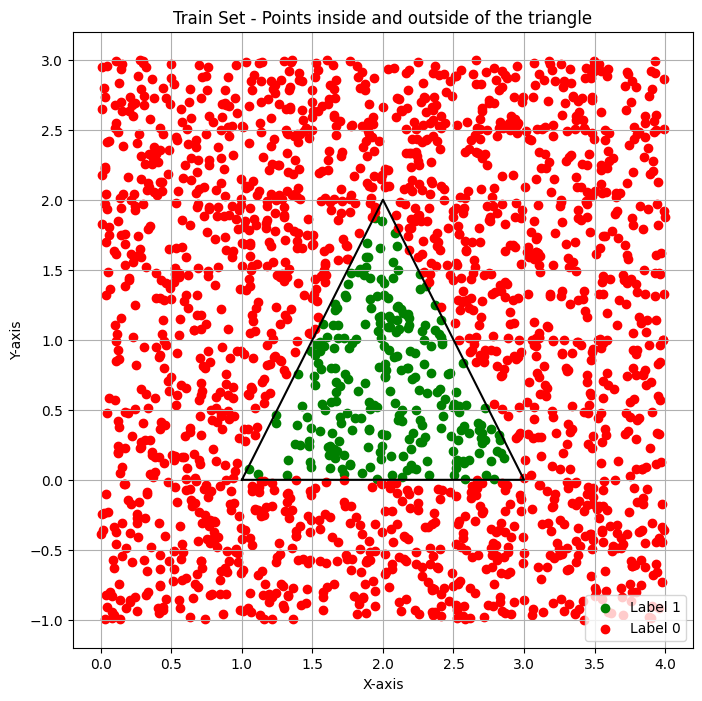

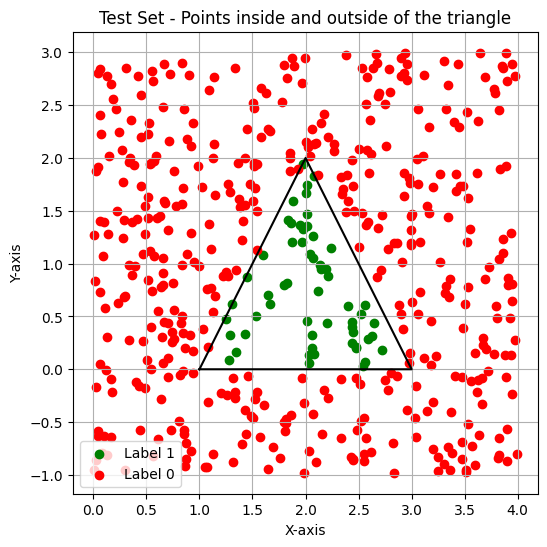

In [2]:
def point_in_triangle(point, v1, v2, v3):
    """Check if point (px, py) is inside the triangle with vertices v1, v2, v3."""
    # Unpack vertices
    x1, y1 = v1
    x2, y2 = v2
    x3, y3 = v3
    px, py = point

    # Vectors
    v0 = (x3 - x1, y3 - y1)
    v1 = (x2 - x1, y2 - y1)
    v2 = (px - x1, py - y1)

    # Dot products
    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)

    # Barycentric coordinates
    invDenom = 1 / (dot00 * dot11 - dot01 * dot01)
    u = (dot11 * dot02 - dot01 * dot12) * invDenom
    v = (dot00 * dot12 - dot01 * dot02) * invDenom

    # Check if point is in triangle
    return (u >= 0) and (v >= 0) and (u + v < 1)

# Triangle vertices
v1 = (1, 0)
v2 = (2, 2)
v3 = (3, 0)

# Generate random points
np.random.seed(53)

x_coords = np.random.uniform(0, 4, 2000)
y_coords = np.random.uniform(-1, 3, 2000)
x_train = np.column_stack((x_coords, y_coords))

x_coords = np.random.uniform(0, 4, 500)
y_coords = np.random.uniform(-1, 3, 500)
x_test = np.column_stack((x_coords, y_coords))

# Label points based on whether they are inside the triangle
y_train = np.array([point_in_triangle(pt, v1, v2, v3) for pt in x_train]).astype(int)
y_test = np.array([point_in_triangle(pt, v1, v2, v3) for pt in x_test]).astype(int)

# Plot points with labels 1 in green and labels 0 in red
plt.figure(figsize=(8, 8))
plt.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], c='green', label='Label 1', )
plt.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], c='red', label='Label 0', )

# Plot the triangle
triangle = np.array([v1, v2, v3, v1])
plt.plot(triangle[:, 0], triangle[:, 1], 'k-')

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Train Set - Points inside and outside of the triangle")
plt.legend()
plt.grid(True)

# Plot points with labels 1 in green and labels 0 in red
plt.figure(figsize=(6, 6))
plt.scatter(x_test[y_test == 1, 0], x_test[y_test == 1, 1], c='green', label='Label 1')
plt.scatter(x_test[y_test == 0, 0], x_test[y_test == 0, 1], c='red', label='Label 0', )

# Plot the triangle
triangle = np.array([v1, v2, v3, v1])
plt.plot(triangle[:, 0], triangle[:, 1], 'k-')

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Test Set - Points inside and outside of the triangle")
plt.legend()
plt.grid(True)

plt.show()

# Models

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, AF=nn.ReLU()):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            AF,
            nn.Linear(hidden_size1, hidden_size2),
            AF,
            nn.Linear(hidden_size2, hidden_size3),
            AF,
            nn.Linear(hidden_size3, output_size),
            nn.Sigmoid()  # Use sigmoid for binary classification, softmax for multi-class
        )

    def forward(self, x):
        return self.layers(x)


# Initialize   

In [112]:
device = "cuda" if torch.cuda.is_available else "cpu"
model = MLP(input_size=2, hidden_size1=8, hidden_size2=64, hidden_size3=8, output_size=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = MLP(input_size=2, hidden_size1=8, hidden_size2=64, hidden_size3=8, output_size=1, AF=nn.ELU()).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.BCELoss()  # For binary classification
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train[:, None], dtype=torch.float32)  # Reshape for BCELoss
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test[:, None], dtype=torch.float32)

# DataLoader
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=512, shuffle=False)


TypeError: __init__() got an unexpected keyword argument 'AF'

# Utils

In [107]:
def plot_metrics(train_loss_hist, test_loss_hist, train_metrics, test_metrics):
    # Calculate recall, precision, and accuracy from metrics
    def calc_stats(metrics):
        recall = [tp / (tp + fn) if (tp + fn) != 0 else 0 for tp, _, _, fn in metrics]
        precision = [tp / (tp + fp) if (tp + fp) != 0 else 0 for tp, fp, _, _ in metrics]
        accuracy = [(tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) != 0 else 0 for tp, fp, tn, fn in metrics]
        return recall, precision, accuracy

    train_recall, train_precision, train_accuracy = calc_stats(train_metrics)
    test_recall, test_precision, test_accuracy = calc_stats(test_metrics)

    epochs = range(1, len(train_loss_hist) + 1)

    # Plotting Loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss_hist, label='Train Loss')
    plt.plot(epochs, test_loss_hist, label='Test Loss')
    plt.title('Train/Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Recall, Precision, Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_recall, label='Train Recall')
    plt.plot(epochs, test_recall, label='Test Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_precision, label='Train Precision')
    plt.plot(epochs, test_precision, label='Test Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_decision_boundary(model, device):
    # Create a grid of points
    x_min, x_max = -1, 4
    y_min, y_max = -1, 4
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict using model
    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(grid_tensor)
        pred = outputs > 0.5

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(grid[:, 0], grid[:, 1], c=pred.cpu().numpy().squeeze(), cmap='bwr', alpha=0.5)
    plt.title('Decision Boundary')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


In [108]:
def plot_decision_boundary(model, device):
    # Create a grid of points
    x_min, x_max = -1, 4
    y_min, y_max = -1, 4
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict using model
    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(grid_tensor)
        pred = outputs > 0.5

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(grid[:, 0], grid[:, 1], c=pred.cpu().numpy().squeeze(), cmap='bwr', alpha=0.5)
    plt.title('Decision Boundary')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()   
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    # Correcting the loop below
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [109]:
def calculate_metrics(outputs, labels):
    # Assuming binary classification and outputs are probabilities
    predicted = outputs > 0.5
    labels = labels > 0.5

    TP = (predicted & labels).sum().item()
    FP = (predicted & ~labels).sum().item()
    TN = (~predicted & ~labels).sum().item()
    FN = (~predicted & labels).sum().item()
    
    return TP, FP, TN, FN



# Train

## MLP with LeakyRelu

In [110]:
num_epochs = 150
train_loss_hist = []
test_loss_hist = []
train_metrics = []
test_metrics = []

for epoch in range(num_epochs):
    loop = tqdm(train_loader)
    model.train()
    train_loss = 0.0
    train_TP, train_FP, train_TN, train_FN = 0, 0, 0, 0

    print("train")
    for inputs, labels in loop:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        TP, FP, TN, FN = calculate_metrics(outputs, labels)
        train_TP += TP
        train_FP += FP
        train_TN += TN
        train_FN += FN
        
        loop.set_postfix(
            epoch=epoch+1,
            total_loss=train_loss / len(train_loader),
        )
    
    train_metrics.append((train_TP, train_FP, train_TN, train_FN))
    train_loss_hist.append(train_loss / len(train_loader))
    
    model.eval()
    torch.cuda.empty_cache()
    test_loss = 0.0
    test_TP, test_FP, test_TN, test_FN = 0, 0, 0, 0
    print("Test:")
    
    with torch.no_grad():
        loop = tqdm(test_loader)
        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
            TP, FP, TN, FN = calculate_metrics(outputs, labels)
            test_TP += TP
            test_FP += FP
            test_TN += TN
            test_FN += FN
            
            loop.set_postfix(
                loss=loss.item(),
                total_loss=test_loss / len(test_loader),
            )
    
    test_metrics.append((test_TP, test_FP, test_TN, test_FN))
    test_loss_hist.append(test_loss / len(test_loader))

# At the end of training, you can print or plot the collected metrics and loss history.
clear_output(wait=False)

### Inference 

C:\Users\mamdaliof\AppData\Local\Temp\ipykernel_21088\335544591.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model(torch.tensor(x_test_tensor).to(device)) >0.5


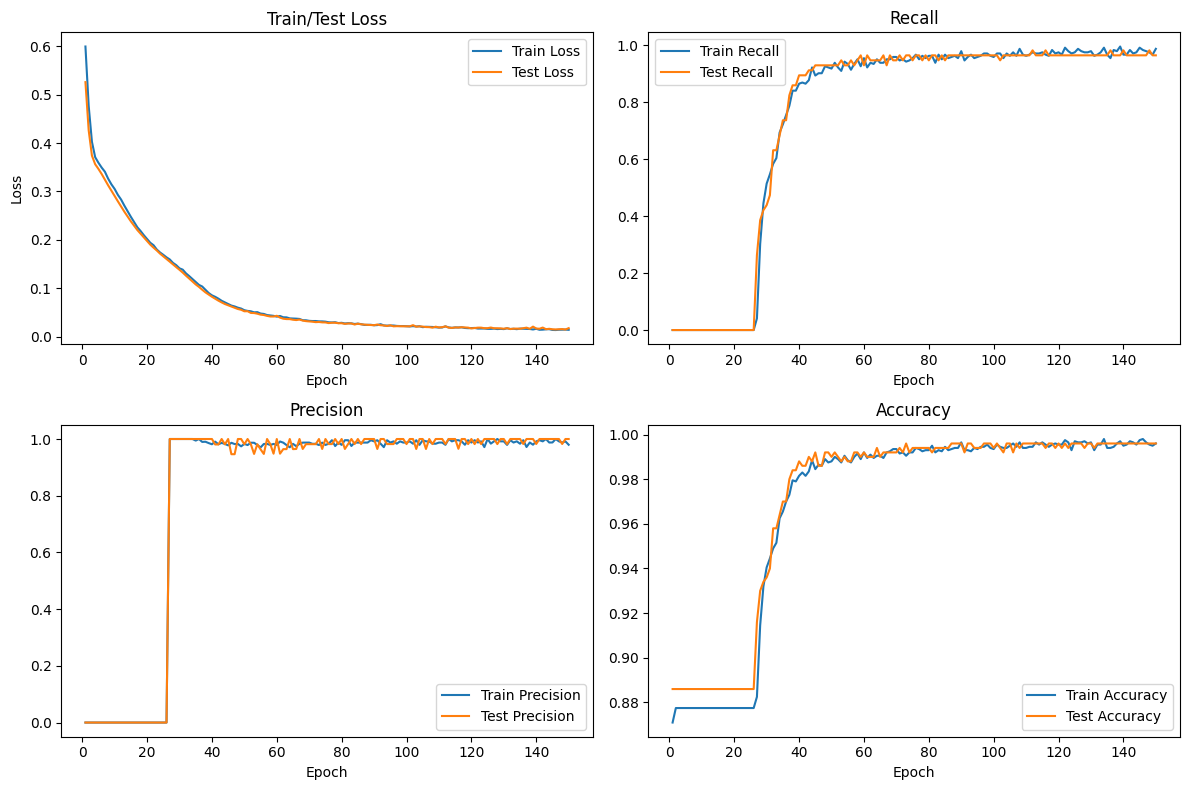

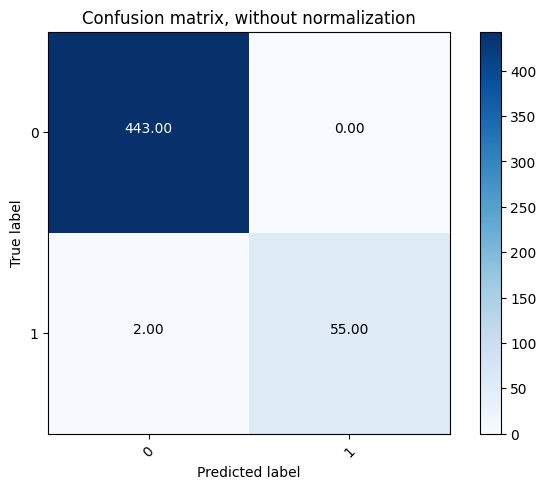

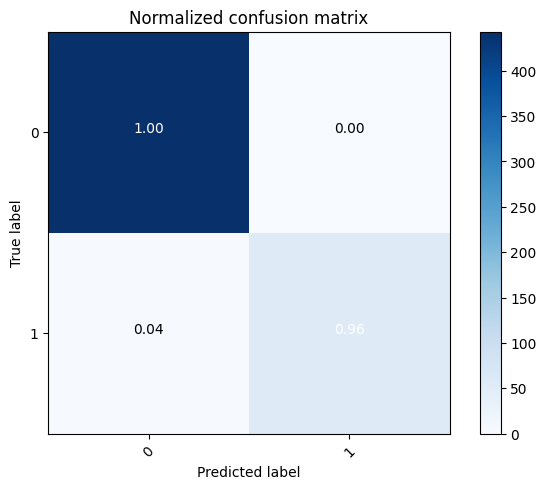

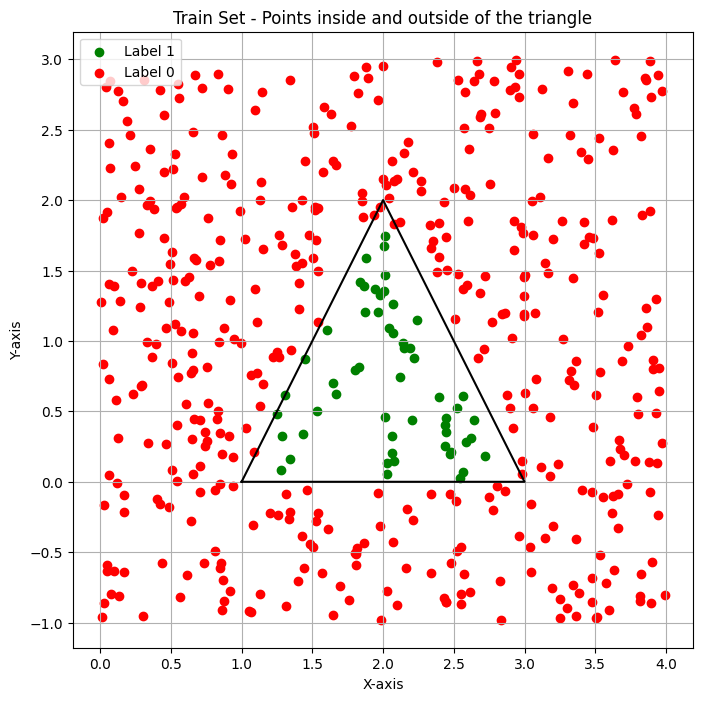

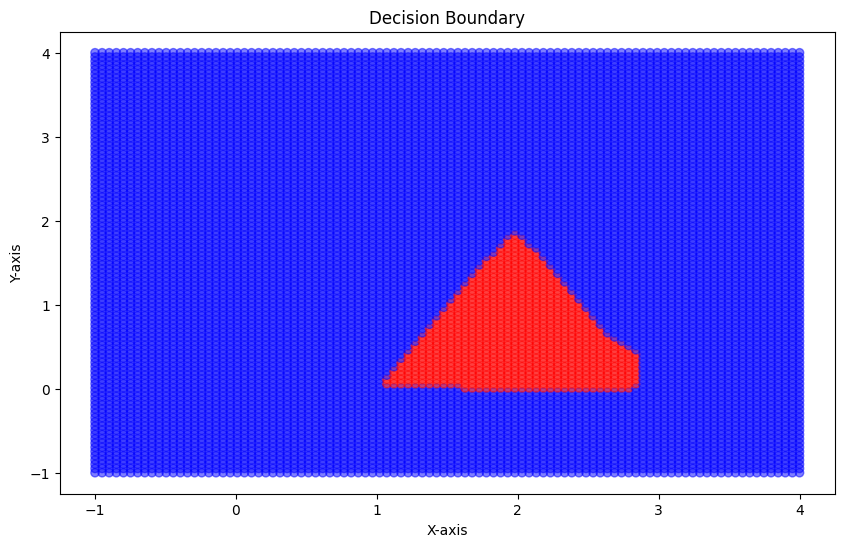

In [111]:
y_pred = model(torch.tensor(x_test_tensor).to(device)) >0.5
y_pred = y_pred.cpu().detach().numpy().astype(int).squeeze()

# Metrics
plot_metrics(train_loss_hist, test_loss_hist, train_metrics, test_metrics)

# Confusion Matrix
cm = confusion_matrix(y_test_tensor, y_pred)
plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], normalize=True, title='Normalized confusion matrix')

# Inference
plt.figure(figsize=(8, 8))
plt.scatter(x_test[y_pred == 1, 0], x_test[y_pred == 1, 1], c='green', label='Label 1', )
plt.scatter(x_test[y_pred == 0, 0], x_test[y_pred == 0, 1], c='red', label='Label 0', )

triangle = np.array([v1, v2, v3, v1])
plt.plot(triangle[:, 0], triangle[:, 1], 'k-')

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Train Set - Points inside and outside of the triangle")
plt.legend()
plt.grid(True)

# Decision Boundary
plot_decision_boundary(model, device)




## MLP with ELU

In [115]:
num_epochs = 150
train_loss_hist = []
test_loss_hist = []
train_metrics = []
test_metrics = []

for epoch in range(num_epochs):
    loop = tqdm(train_loader)
    model.train()
    train_loss = 0.0
    train_TP, train_FP, train_TN, train_FN = 0, 0, 0, 0

    print("train")
    for inputs, labels in loop:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        TP, FP, TN, FN = calculate_metrics(outputs, labels)
        train_TP += TP
        train_FP += FP
        train_TN += TN
        train_FN += FN
        
        loop.set_postfix(
            epoch=epoch+1,
            total_loss=train_loss / len(train_loader),
        )
    
    train_metrics.append((train_TP, train_FP, train_TN, train_FN))
    train_loss_hist.append(train_loss / len(train_loader))
    
    model.eval()
    torch.cuda.empty_cache()
    test_loss = 0.0
    test_TP, test_FP, test_TN, test_FN = 0, 0, 0, 0
    print("Test:")
    
    with torch.no_grad():
        loop = tqdm(test_loader)
        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
            TP, FP, TN, FN = calculate_metrics(outputs, labels)
            test_TP += TP
            test_FP += FP
            test_TN += TN
            test_FN += FN
            
            loop.set_postfix(
                loss=loss.item(),
                total_loss=test_loss / len(test_loader),
            )
    
    test_metrics.append((test_TP, test_FP, test_TN, test_FN))
    test_loss_hist.append(test_loss / len(test_loader))

# At the end of training, you can print or plot the collected metrics and loss history.
clear_output(wait=False)

## Inference

C:\Users\mamdaliof\AppData\Local\Temp\ipykernel_21088\335544591.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model(torch.tensor(x_test_tensor).to(device)) >0.5


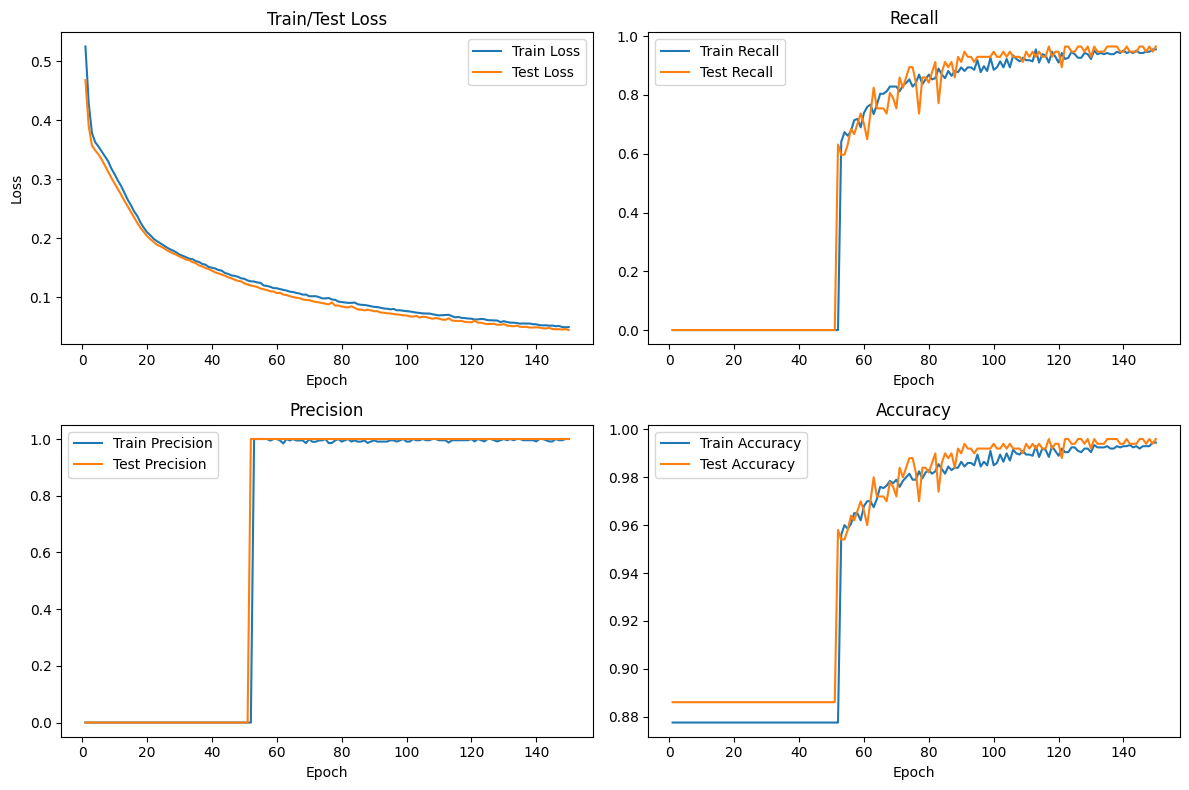

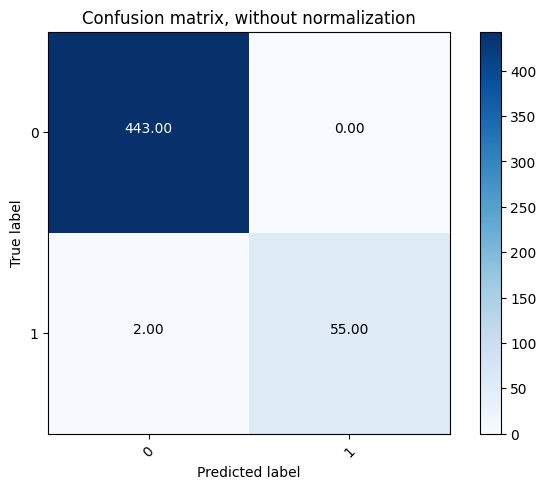

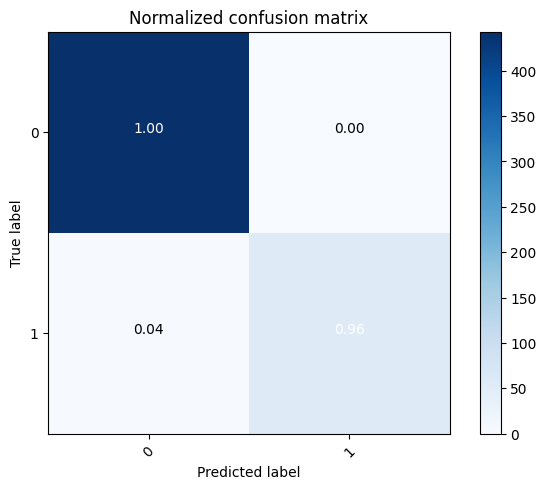

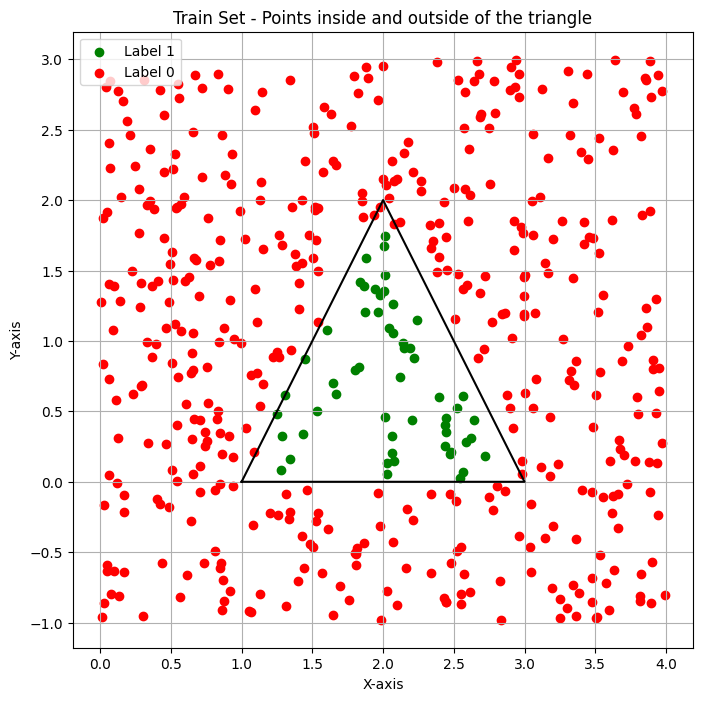

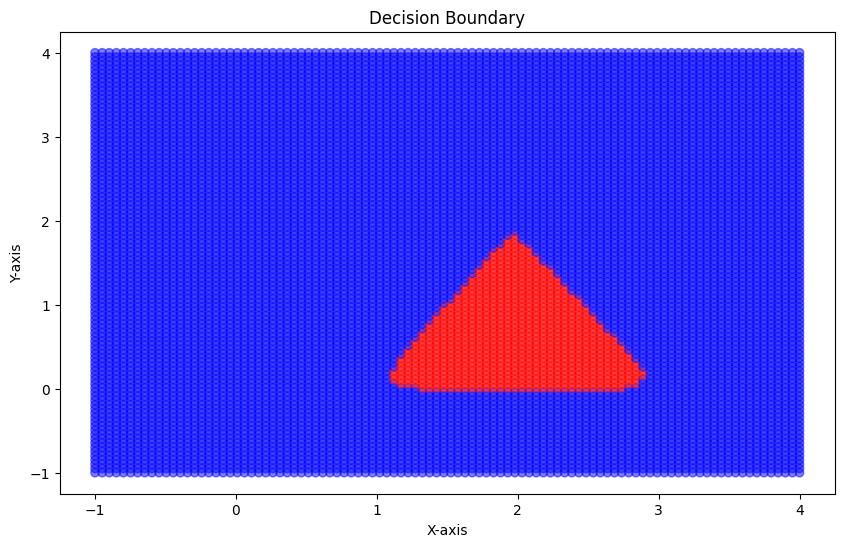

In [116]:
y_pred = model(torch.tensor(x_test_tensor).to(device)) >0.5
y_pred = y_pred.cpu().detach().numpy().astype(int).squeeze()

# Metrics
plot_metrics(train_loss_hist, test_loss_hist, train_metrics, test_metrics)

# Confusion Matrix
cm = confusion_matrix(y_test_tensor, y_pred)
plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], normalize=True, title='Normalized confusion matrix')

# Inference
plt.figure(figsize=(8, 8))
plt.scatter(x_test[y_pred == 1, 0], x_test[y_pred == 1, 1], c='green', label='Label 1', )
plt.scatter(x_test[y_pred == 0, 0], x_test[y_pred == 0, 1], c='red', label='Label 0', )

triangle = np.array([v1, v2, v3, v1])
plt.plot(triangle[:, 0], triangle[:, 1], 'k-')

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Train Set - Points inside and outside of the triangle")
plt.legend()
plt.grid(True)

# Decision Boundary
plot_decision_boundary(model, device)




# Mc Culloch-Pitts

In [127]:
#define muculloch pitts
class McCulloch_Pitts_neuron():

  def __init__(self , weights ,bias, threshold):
    self.weights = np.array(weights).reshape(-1, 1)     #define weights
    self.threshold = threshold    #define threshold
    self.bias = np.array(bias)
    
  def model(self , x):
    #define model with threshold
    return (x.T @ self.weights + self.bias >= self.threshold).astype(int)
    
def model(x):
    neur1 = McCulloch_Pitts_neuron([-2, 1],2, 0)
    neur2 = McCulloch_Pitts_neuron([2, 1], -6, 0)
    neur3 = McCulloch_Pitts_neuron([0, 1], 0, 0)
    neur4 = McCulloch_Pitts_neuron([1, 1, 1], 0, 3)

    z1 = neur1.model(np.array(x))
    z2 = neur2.model(np.array(x))
    z3 = neur3.model(np.array(x))
    z4 = np.squeeze(np.array([1-z1, 1-z2, z3]), axis=-1)
    z4 = neur4.model(z4)

    # 3 bit output
    # return str(z1) + str(z2)
    return z4



In [144]:
def plot_decision_boundary(model):
    # Create a grid of points
    x_min, x_max = -1, 4
    y_min, y_max = -1, 4
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict using model

    outputs = model(grid.T)
    pred = outputs > 0.5

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(grid[:, 0], grid[:, 1], c=pred.squeeze(), cmap='bwr', alpha=0.5)
    plt.title('Decision Boundary')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

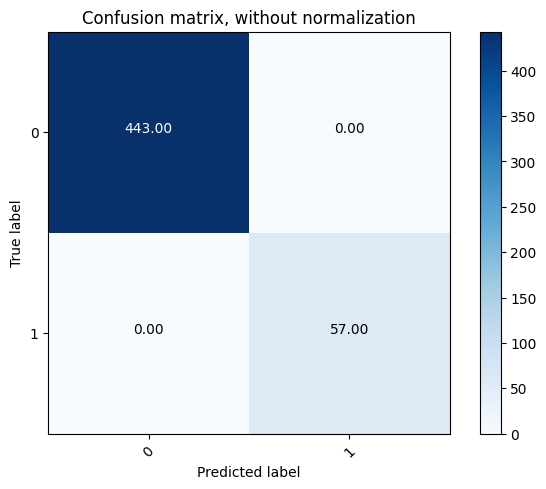

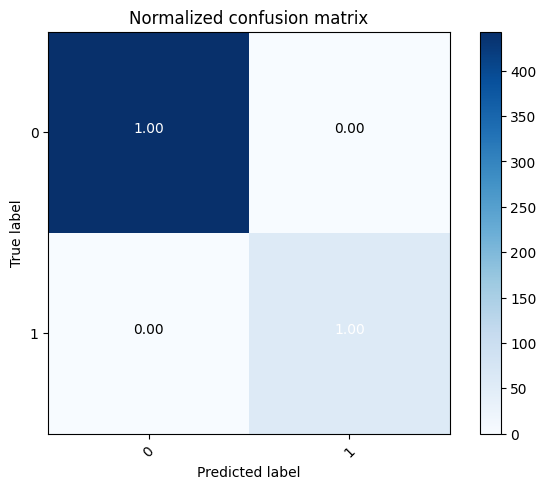

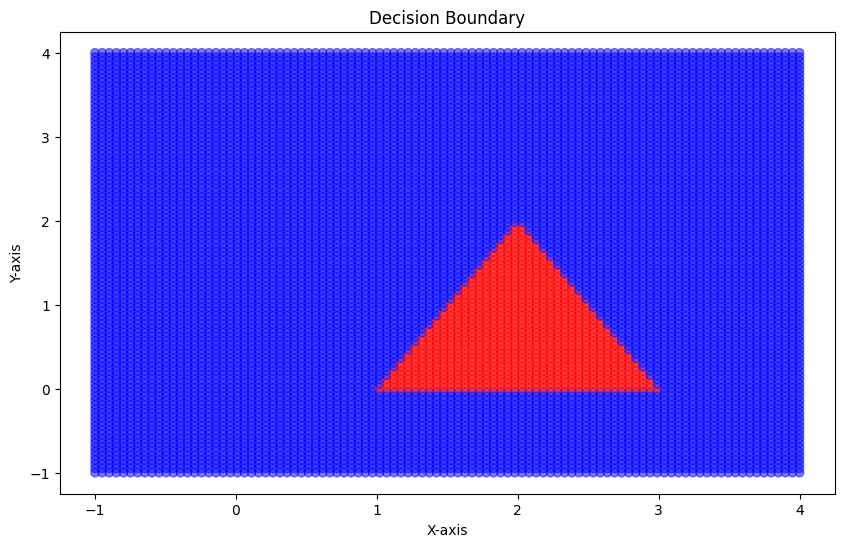

In [145]:

y_pred = model(x_test.T)
cm = confusion_matrix(y_test, y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[0, 1], normalize=True, title='Normalized confusion matrix')

plt.show()
plot_decision_boundary(model)